In [150]:
import pandas as pd

# Load data (replace with your actual path)
df = pd.read_csv("../data/cleaned_sales.csv")

# Check first few rows and columns
print(df.head())
print("Columns:", df.columns)

   InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55       17850  United Kingdom  
1  2010-12-01 08:26:00       3.39       17850  United Kingdom  
2  2010-12-01 08:26:00       2.75       17850  United Kingdom  
3  2010-12-01 08:26:00       3.39       17850  United Kingdom  
4  2010-12-01 08:26:00       3.39       17850  United Kingdom  
Columns: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [151]:
# Convert to datetime and extract date-only
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['ds'] = df['InvoiceDate'].dt.date  # Create 'ds' column for Prophet
df['ds'] = pd.to_datetime(df['ds'])   # Ensure it's datetime type

In [152]:
# Replace 'Revenue' with your actual sales column (e.g., 'Quantity * UnitPrice')
if 'Revenue' not in df.columns:
    df['Revenue'] = df['Quantity'] * df['UnitPrice']  # Calculate if missing [[8]]

# Aggregate daily sales
daily_sales = df.groupby('ds')['Revenue'].sum().reset_index()
daily_sales.rename(columns={'Revenue': 'y'}, inplace=True)  # Prophet requires 'y'

In [153]:
train = daily_sales[daily_sales['ds'] < '2011-12-31']
test = daily_sales[daily_sales['ds'] >= '2011-10-01']

In [154]:

from prophet import Prophet
import joblib

model = Prophet(
    changepoint_prior_scale=0.01,  # More flexible trend detection
    weekly_seasonality=True,  # Weekly seasonality
    yearly_seasonality=True,  # Yearly seasonality
    daily_seasonality=False,  # Daily seasonality not needed
    
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.1)
model.fit(train)

#Save Model
joblib.dump(model, "../models/sales_forecast_model.pkl")

01:08:28 - cmdstanpy - INFO - Chain [1] start processing
01:08:28 - cmdstanpy - INFO - Chain [1] done processing


['../models/sales_forecast_model.pkl']

In [155]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Compare predictions to test set
test_forecast = forecast[forecast['ds'].isin(test['ds'])]
mae = abs(test['y'] - test_forecast['yhat']).mean()
print(f"MAE: {mae:.2f}")

MAE: 11888.51


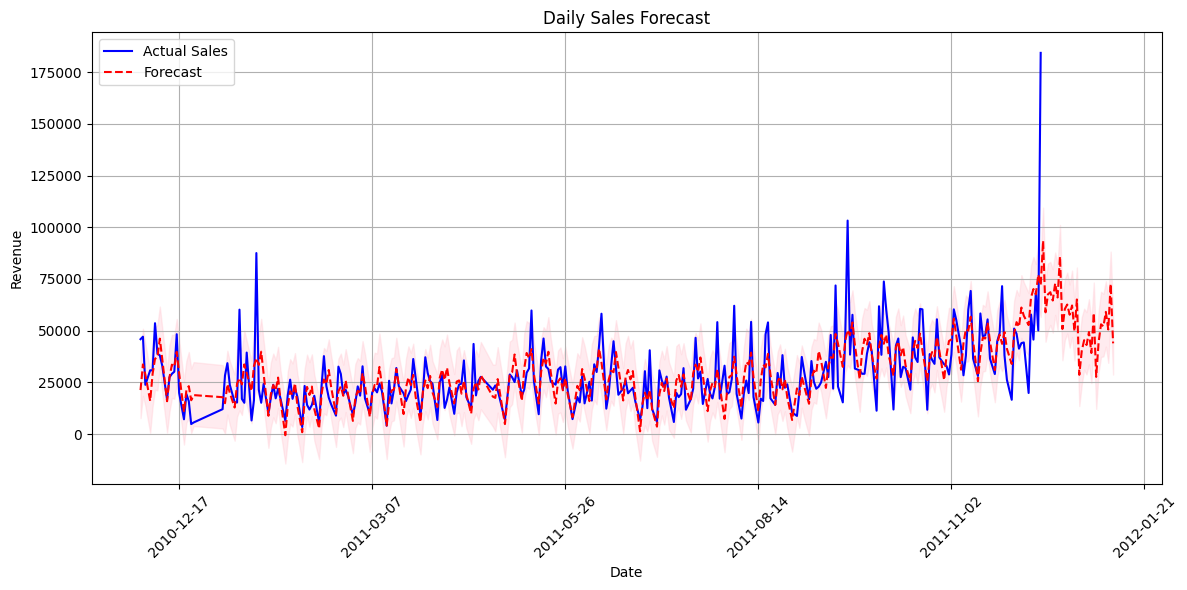

In [156]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot actual vs forecasted sales
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['ds'], daily_sales['y'], label='Actual Sales', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)

# Format axes and labels
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Daily Sales Forecast')
plt.legend()
plt.grid(True)

# Improve date formatting
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))  # Limit x-axis date ticks
plt.xticks(rotation=45)
plt.tight_layout()

# Save or display
plt.savefig("sales_forecast.png")  # Save to file
plt.show()  # Or use this to display directly